<a href="https://colab.research.google.com/github/JYP97/DS2_Proj_Jobs_skills_analysis/blob/master/DS2_BERT_Fine_Tuning_Sentence_Classification_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Tutorial with PyTorch

By Chris McCormick and Nick Ryan

*Revised on March 20, 2020 - Switched to `tokenizer.encode_plus` and added validation loss. See [Revision History](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=IKzLS9ohzGVu) at the end for details.*




In this tutorial I'll show you how to use BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification. More broadly, I describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks.

This post is presented in two forms--as a blog post [here](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) and as a Colab Notebook [here](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX). 

The content is identical in both, but: 
* The blog post includes a comments section for discussion. 
* The Colab Notebook will allow you to run the code and inspect it as you read through.

I've also published a video walkthrough of this post on my YouTube channel! [Part 1](https://youtu.be/x66kkDnbzi4) and [Part 2](https://youtu.be/Hnvb9b7a_Ps).



# Introduction


## History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.



## What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

This post will explain how you can modify and fine-tune BERT to create a powerful NLP model that quickly gives you state of the art results. 



## Advantages of Fine-Tuning



In this tutorial, we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

1. **Quicker Development**

    * First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!). 

2. **Less Data**

    * In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. **Better Results**

    * Finally, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.



### A Shift in NLP

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.

Let's get started!

# 1. Setup

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [ ]:
# !pip install transformers
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on. 

# 2. Loading Dataset


We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
# df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = pd.read_csv("/content/drive/MyDrive/DS2/valid_salary_dataset.csv")
df = df.drop(columns = ["Unnamed: 0", "salary",	"education", "description", "experience", "employment_type"])
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
display(df)

Number of training sentences: 948



,title,job category,skills
0,Head Start Teacher,Managers,Emergency Handling
1,Teacher of English for Online Groups,Professionals,"Vocabularies, Grammars, Teaching, Lesson Plann..."
2,CRM / PHP Developer,Professionals,"PHP (Scripting Language), Debugging, Web Servi..."
3,Licensed Nursing Home Administrator,Managers,"Emergency Handling, Training, Accounting, Heal..."
4,Sales Leader,Managers,"Training, Recruitment, Direct Selling, Sales, ..."
...,...,...,...
943,Microstrategy Programmer/Analyst,Professionals,"Analysis, TAFIM, Business Intelligence, Archit..."
944,Entry Level Sales Representative: Complete Tra...,Service and sales workers,"Time Management, Attention To Detail, Customer..."
945,Customer Service Representative (CRM),Clerical support workers,"Retailing, Hospitality, Sales, Merchandising, ..."
946,Automotive Technicians / Master Level Technicians,Technicians and associate professionals,"Diagnostic Tools, Steering, Brakes, Suspension..."




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
labels = [label for label in df['job category'].unique() if not pd.isnull(label)]

label2id = {'Armed forces occupations':0,
          'Managers':1,
          'Professionals':2,
          'Technicians and associate professionals':3,
          'Clerical support workers':4,
          'Service and sales workers':5,
          'Skilled agricultural, forestry and fishery workers':6,
          'Craft and related trades workers':7,
          'Plant and machine operators and assemblers':8,
          'Elementary occupations':9
          }
# target = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
id2label = {idx:label for label, idx in label2id.items()}

# labels = torch.nn.functional.one_hot(target)

labels

['Managers',
 'Professionals',
 'Service and sales workers',
 'Plant and machine operators and assemblers',
 'Craft and related trades workers',
 'Technicians and associate professionals',
 'Clerical support workers',
 'Elementary occupations',
 'Skilled agricultural, forestry and fishery workers',
 'Armed forces occupations']

In [ ]:
df['labels'] = df['job category'].replace(label2id)

In [ ]:
display(df)

,title,job category,skills,labels
0,Head Start Teacher,Managers,Emergency Handling,1
1,Teacher of English for Online Groups,Professionals,"Vocabularies, Grammars, Teaching, Lesson Plann...",2
2,CRM / PHP Developer,Professionals,"PHP (Scripting Language), Debugging, Web Servi...",2
3,Licensed Nursing Home Administrator,Managers,"Emergency Handling, Training, Accounting, Heal...",1
4,Sales Leader,Managers,"Training, Recruitment, Direct Selling, Sales, ...",1
...,...,...,...,...
943,Microstrategy Programmer/Analyst,Professionals,"Analysis, TAFIM, Business Intelligence, Archit...",2
944,Entry Level Sales Representative: Complete Tra...,Service and sales workers,"Time Management, Attention To Detail, Customer...",5
945,Customer Service Representative (CRM),Clerical support workers,"Retailing, Hospitality, Sales, Merchandising, ...",4
946,Automotive Technicians / Master Level Technicians,Technicians and associate professionals,"Diagnostic Tools, Steering, Brakes, Suspension...",3


## 2.3 Train/Test-set Split

In [ ]:
from sklearn.model_selection import train_test_split

# Divide the dataset by randomly selecting samples.
text_train, text_test, label_train, label_test = train_test_split(df['skills'], df['labels'], 
                                    test_size=0.20, 
                                    random_state=42, shuffle=True)


print('{:>5,} training samples'.format(len(text_train)))
print('{:>5,} test samples'.format(len(text_test)))

temp_dataset = pd.concat((text_train, label_train), axis=1).reset_index(drop=True)
test_dataset = pd.concat((text_test, label_test), axis=1).reset_index(drop=True)

temp_dataset.to_csv('/content/drive/MyDrive/DS2/train-val-dataset-with-salary.csv')  
test_dataset.to_csv('/content/drive/MyDrive/DS2/test-dataset-with-salary.csv')  

  758 training samples
  190 test samples


# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/DS2/train-val-dataset-with-salary.csv", index_col=0)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
display(train_df)

Number of training sentences: 758



,skills,labels
0,"Microsoft Excel, Derivatives, Revenues, Accoun...",1
1,"SolidWorks (CAD), Attention To Detail, Warehou...",9
2,"VHSIC Hardware Description Language (VHDL), St...",2
3,"Coordinating, Scheduling, Data Entry, Medical ...",4
4,"Depreciation, Balance Sheet, Fixed Asset, Gene...",2
...,...,...
753,"Financial Statements, Income Statement, Balanc...",1
754,"Accounts Receivable, Accounts Payable, Billing...",4
755,"Finance, Reports, Mergers And Acquisitions, On...",2
756,"Computer Literacy, Forklift Truck",8


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', train_df['skills'][1])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_df['skills'][1]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_df['skills'][1])))

 Original:  SolidWorks (CAD), Attention To Detail, Warehousing
Tokenized:  ['solid', '##works', '(', 'cad', ')', ',', 'attention', 'to', 'detail', ',', 'ware', '##ho', '##using']
Token IDs:  [5024, 9316, 1006, 28353, 1007, 1010, 3086, 2000, 6987, 1010, 16283, 6806, 18161]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

*Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.*

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Special Tokens



**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

I am not certain yet why the token is still required when we have only single-sentence input, but it is!


**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

You might think to try some pooling strategy over the final embeddings, but this isn't necessary. Because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector. It's already done the pooling for us!



### Sentence Length & Attention Mask



The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`








[![BERT eBook Display Ad](https://drive.google.com/uc?export=view&id=1d6L584QYqpREpRIwAZ55Wsq8AUs5qSk1)](https://www.chrismccormick.ai/bert-ebook?utm_source=colab&utm_medium=banner&utm_campaign=bert_ebook&utm_content=colab0)


## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [ ]:
max_len = 0

# For every sentence...
for skill in train_df['skills']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(skill, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  213


Just in case there are some longer test sentences, I'll set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for skill in train_df['skills']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        skill,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_df.labels.values)
# labels = torch.tensor(ids).float()
# torch.unsqueeze(labels, 1)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_df['skills'][0])
print('Token IDs:', input_ids[0])
print('attention_masks:', attention_masks[0])
print('labels:', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Microsoft Excel, Derivatives, Revenues, Accounting, Certified Public Accountant, Data Manipulation, Business Process Improvement, Information Technology
Token IDs: tensor([  101,  7513, 24970,  1010, 16942,  1010, 12594,  1010,  9529,  1010,
         7378,  2270, 17907,  1010,  2951, 16924,  1010,  2449,  2832,  7620,
         1010,  2592,  2974,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   

## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(0.70 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  530 training samples
  228 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 10, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 30

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 666

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
best_f1 = 0

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0
    predictions , true_labels = [], []

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_train_accuracy += flat_accuracy(logits, label_ids)

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        # Store predictions and true labels
        predictions.extend(pred_flat)
        true_labels.extend(labels_flat)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            

    print("")
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_train_accuracy))
    
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    f1_train = f1_score(y_pred=predictions, y_true=true_labels, average='macro')
    print("  F1 score: {0:.2f}".format(f1_train)) 
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("  Training epoch took: {:}".format(training_time))
    
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    predictions , true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        # Store predictions and true labels
        predictions.extend(pred_flat)
        true_labels.extend(labels_flat)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    f1_val = f1_score(y_pred=predictions, y_true=true_labels, average='macro')
    print("  F1 score: {0:.2f}".format(f1_val))

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Validation took: {:}".format(validation_time))

    if(f1_macro > best_f1):
        model.save_pretrained("/content/drive/MyDrive/DataScience/DS2/f1_models")
        print("  New best model saved!")
        best_f1 = f1_macro

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Training F1': f1_train,
            'Training Time': training_time,
            'Valid. Accur.': avg_val_accuracy,
            'Valid. Loss': avg_val_loss,
            'Valid. F1': f1_val,
            'Valid. Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 30 ========
Training...

  Accuracy: 0.87
  Average training loss: 0.67
  Training epoch took: 0:00:22

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.65
  Validation took: 0:00:03
  New best model saved!

======== Epoch 2 / 30 ========
Training...

  Accuracy: 0.93
  Average training loss: 0.29
  Training epoch took: 0:00:23

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.60
  Validation took: 0:00:03
  New best model saved!

======== Epoch 3 / 30 ========
Training...

  Accuracy: 0.94
  Average training loss: 0.23
  Training epoch took: 0:00:22

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.61
  Validation took: 0:00:03
  New best model saved!

======== Epoch 4 / 30 ========
Training...

  Accuracy: 0.96
  Average training loss: 0.19
  Training epoch took: 0:00:22

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.61
  Validation took: 0:00:03

======== Epoch 5 / 30 ========
Training...

  Accuracy: 0.96
  Average 

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Accur.,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,0.87,0.67,0.65,0.87,0:00:22,0:00:03
2,0.93,0.29,0.60,0.88,0:00:23,0:00:03
3,0.94,0.23,0.61,0.88,0:00:22,0:00:03
4,0.96,0.19,0.61,0.88,0:00:22,0:00:03
5,0.96,0.15,0.67,0.88,0:00:22,0:00:03
6,0.97,0.11,0.66,0.88,0:00:22,0:00:03
7,0.98,0.07,0.66,0.88,0:00:22,0:00:03
8,0.98,0.07,0.68,0.88,0:00:22,0:00:03
9,0.98,0.06,0.73,0.87,0:00:22,0:00:03


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

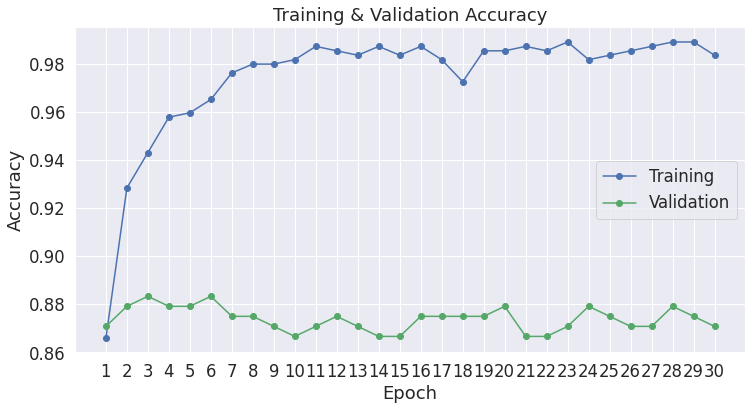

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Accur.'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([x+1 for x in range(epochs)])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
test_df = pd.read_csv("/content/drive/MyDrive/DS2/test-dataset-with-salary.csv", index_col=0)

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

display(test_df)

Number of test sentences: 190



,skills,labels
0,"Scheduling, Management, Construction Managemen...",4
1,"Children'S Health Insurance Program, Chromatin...",2
2,"Outline Of Food Preparation, Cooking, Restaura...",5
3,"Retailing, Scheduling, Customer Service, Sales...",3
4,"Scheduling, Time Management, Communication, Re...",4
...,...,...
185,"Sales, Marketing, Direct Marketing, Team-worki...",5
186,"Instructions, Assembling",8
187,"Self Motivation, Communication, Social Skills",3
188,"Clerical Works, Administration, Manufacturing,...",4


In [ ]:
# Create sentence and label lists
skills = test_df.skills.values
labels = test_df.labels.values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for skill in skills:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        skill,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Load the saved parameters

model = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/DataScience/DS2/models", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 10, # The number of output labels: 2 for binary classification. 
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from datasets import load_dataset, load_metric
from sklearn.metrics import f1_score

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# metric = load_metric("glue", "mrpc")

# Tracking variables 
predictions , true_labels = [], []

total_test_accuracy = 0
total_test_loss = 0
nb_test_steps = 0

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  pred_flat = np.argmax(logits, axis=1).flatten()
  labels_flat = label_ids.flatten()

  # Store predictions and true labels
  predictions.extend(pred_flat)
  true_labels.extend(labels_flat)

  total_test_accuracy += flat_accuracy(logits, label_ids)
    
print("")
# Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(prediction_dataloader)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
  
print("  F1 score: {0:.2f}".format(f1_score(y_pred=predictions, y_true=true_labels, average='macro'))) 

# Measure how long the validation run took.
test_time = format_time(time.time() - t0)
print("  Test took: {:}".format(test_time))

print("")
print("Test complete!")

Predicting labels for 190 test sentences...

  Accuracy: 0.98
  Test Loss: 0.00
  F1 score: 0.27
  Test took: 1:48:00

Test complete!


In [ ]:
predictions

[array([1, 3, 7, 5, 2, 3, 2, 2, 2, 2, 3, 1, 3, 8, 2, 2, 3, 2, 2, 4, 8, 1,
        1, 4, 2, 4, 3, 3, 2, 3, 2, 8]),
 array([9, 3, 5, 3, 3, 7, 2, 8, 9, 4, 2, 3, 2, 8, 1, 4, 8, 1, 2, 5, 2, 2,
        4, 1, 2, 8, 1, 3, 4, 2, 9, 8]),
 array([3, 2, 3, 2, 1, 5, 3, 2, 3, 1, 2, 2, 5, 1, 2, 1, 5, 1, 3, 3, 1, 3,
        2, 2, 8, 3, 8, 2, 1, 8, 1, 3]),
 array([2, 9, 9, 2, 1, 8, 5, 3, 2, 7, 3, 1, 1, 3, 5, 2, 2, 3, 5, 1, 4, 5,
        1, 4, 4, 4, 1, 1, 2, 2, 2, 5]),
 array([8, 5, 2, 2, 2, 2, 2, 3, 8, 2, 4, 3, 2, 1, 2, 5, 4, 3, 1, 4, 1, 2,
        1, 1, 2, 2, 2, 2, 4, 3, 2, 1]),
 array([3, 5, 3, 1, 2, 2, 2, 3, 9, 3, 7, 2, 3, 2, 2, 1, 1, 2, 2, 5, 5, 7,
        7, 4, 8, 2, 8, 5, 3, 4])]

In [ ]:
true_labels

[array([4, 2, 5, 3, 4, 5, 2, 2, 2, 2, 8, 2, 3, 3, 2, 4, 1, 2, 2, 5, 8, 5,
        4, 1, 5, 4, 3, 8, 2, 3, 1, 7]),
 array([9, 2, 3, 1, 9, 8, 2, 9, 8, 5, 3, 3, 3, 8, 1, 5, 1, 1, 5, 4, 2, 4,
        4, 1, 3, 7, 1, 8, 5, 1, 8, 9]),
 array([8, 2, 3, 2, 2, 4, 2, 3, 0, 1, 2, 2, 2, 1, 2, 1, 7, 2, 3, 8, 3, 1,
        3, 5, 7, 2, 8, 4, 4, 8, 2, 8]),
 array([2, 7, 9, 2, 1, 4, 2, 2, 3, 4, 1, 2, 2, 4, 4, 2, 1, 3, 5, 2, 9, 9,
        1, 4, 2, 7, 1, 1, 1, 2, 3, 2]),
 array([3, 2, 2, 2, 2, 1, 2, 4, 2, 2, 1, 2, 2, 2, 2, 4, 4, 3, 1, 5, 2, 2,
        2, 1, 3, 5, 2, 2, 2, 1, 3, 2]),
 array([8, 5, 7, 1, 2, 7, 1, 2, 8, 1, 9, 3, 1, 2, 5, 2, 5, 3, 2, 3, 5, 8,
        7, 7, 3, 5, 8, 3, 4, 4])]

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

total_test_accuracy = 0
total_test_loss = 0
nb_test_steps = 0

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  # Calculate the accuracy for this batch of test sentences, and
  # accumulate it over all batches.
  total_test_accuracy += flat_accuracy(logits, label_ids)
    
print("")
# Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(prediction_dataloader)

# Measure how long the validation run took.
test_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))

print("")
print("Test complete!")

Predicting labels for 190 test sentences...
[1 3 7 5 2 3 2 2 2 2 3 1 3 8 2 2 3 2 2 4 8 1 1 4 2 4 3 3 2 3 2 8]
[4 2 5 3 4 5 2 2 2 2 8 2 3 3 2 4 1 2 2 5 8 5 4 1 5 4 3 8 2 3 1 7]
[9 3 5 3 3 7 2 8 9 4 2 3 2 8 1 4 8 1 2 5 2 2 4 1 2 8 1 3 4 2 9 8]
[9 2 3 1 9 8 2 9 8 5 3 3 3 8 1 5 1 1 5 4 2 4 4 1 3 7 1 8 5 1 8 9]
[3 2 3 2 1 5 3 2 3 1 2 2 5 1 2 1 5 1 3 3 1 3 2 2 8 3 8 2 1 8 1 3]
[8 2 3 2 2 4 2 3 0 1 2 2 2 1 2 1 7 2 3 8 3 1 3 5 7 2 8 4 4 8 2 8]
[2 9 9 2 1 8 5 3 2 7 3 1 1 3 5 2 2 3 5 1 4 5 1 4 4 4 1 1 2 2 2 5]
[2 7 9 2 1 4 2 2 3 4 1 2 2 4 4 2 1 3 5 2 9 9 1 4 2 7 1 1 1 2 3 2]
[8 5 2 2 2 2 2 3 8 2 4 3 2 1 2 5 4 3 1 4 1 2 1 1 2 2 2 2 4 3 2 1]
[3 2 2 2 2 1 2 4 2 2 1 2 2 2 2 4 4 3 1 5 2 2 2 1 3 5 2 2 2 1 3 2]
[3 5 3 1 2 2 2 3 9 3 7 2 3 2 2 1 1 2 2 5 5 7 7 4 8 2 8 5 3 4]
[8 5 7 1 2 7 1 2 8 1 9 3 1 2 5 2 5 3 2 3 5 8 7 7 3 5 8 3 4 4]

  Accuracy: 0.98
  Test Loss: 0.00
  Test took: 1:44:03

Test complete!


# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K ./model_save/

The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

The following functions will load the model back from disk.

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

## A.2. Weight Decay



The huggingface example includes the following code block for enabling weight decay, but the default decay rate is "0.0", so I moved this to the appendix.

This block essentially tells the optimizer to not apply weight decay to the bias terms (e.g., $ b $ in the equation $ y = Wx + b $ ). Weight decay is a form of regularization--after calculating the gradients, we multiply them by, e.g., 0.99.

In [ ]:
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

# Revision History

**Version 4** - *Feb 2nd, 2020* - (current)
* Updated all calls to `model` (fine-tuning and evaluation) to use the [`SequenceClassifierOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput) class.
* Moved illustration images to Google Drive--Colab appears to no longer support images at external URLs.

**Version 3** - *Mar 18th, 2020*
* Simplified the tokenization and input formatting (for both training and test) by leveraging the `tokenizer.encode_plus` function. 
`encode_plus` handles padding *and* creates the attention masks for us.
* Improved explanation of attention masks.
* Switched to using `torch.utils.data.random_split` for creating the training-validation split.
* Added a summary table of the training statistics (validation loss, time per epoch, etc.).
* Added validation loss to the learning curve plot, so we can see if we're overfitting. 
    * Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing this!
* Displayed the per-batch MCC as a bar plot.

**Version 2** - *Dec 20th, 2019* - [link](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP)
* huggingface renamed their library to `transformers`. 
* Updated the notebook to use the `transformers` library.

**Version 1** - *July 22nd, 2019*
* Initial version.

## Further Work

* It might make more sense to use the MCC score for “validation accuracy”, but I’ve left it out so as not to have to explain it earlier in the Notebook.
* Seeding -- I’m not convinced that setting the seed values at the beginning of the training loop is actually creating reproducible results…
* The MCC score seems to vary substantially across different runs. It would be interesting to run this example a number of times and show the variance.
